# Backdoor v4: Unemployment Risk Ratio

In [1]:
import sys

In [2]:
# append parent directory to use utils
sys.path.append("../")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.backdoor_utils import backdoor_classifier
from utils.bootstrap import bootstrap_experiment

In [4]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

In [5]:
lalonde_exp.shape, lalonde_obs.shape

((445, 13), (2675, 13))

In [6]:
lalonde_exp["u78"] = lalonde_exp["re78"].apply(lambda x: 1 if x == 0 else 0)
lalonde_obs["u78"] = lalonde_obs["re78"].apply(lambda x: 1 if x == 0 else 0)

## Naive Estimate

In [14]:
(
    lalonde_exp.loc[lalonde_exp["treat"] == 1, "u75"]
    / lalonde_exp.loc[lalonde_exp["treat"] == 1, "u78"]
) - (
    lalonde_exp.loc[lalonde_exp["treat"] == 0, "u75"]
    - lalonde_exp.loc[lalonde_exp["treat"] == 0, "u78"]
)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
440   NaN
441   NaN
442   NaN
443   NaN
444   NaN
Length: 445, dtype: float64

In [13]:
(
    lalonde_exp.loc[lalonde_exp["treat"] == 0, "u75"]
    - lalonde_exp.loc[lalonde_exp["treat"] == 0, "u78"]
).mean()

0.33076923076923076

## Using a Classifier

### Experimental Data

In [8]:
backdoor_result = backdoor_classifier(
    lalonde_exp,
    "treat",
    "u78",
    ["age", "education", "black", "hispanic", "married", "u74", "u75"],
    "LogisticRegression",
)
print(f"The risk ratio is {backdoor_result:.2f}")

The risk ratio is 0.40


In [9]:
backdoor_result = backdoor_classifier(
    lalonde_exp,
    "treat",
    "u78",
    ["age", "education", "black", "hispanic", "married", "u74", "u75"],
    "DecisionTree",
)
print(f"The risk ratio is {backdoor_result:.2f}")

The risk ratio is 0.79


In [10]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_classifier,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="u78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "u74",
        "u75",
    ],
    classifier_name="DecisionTree",
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.57it/s]


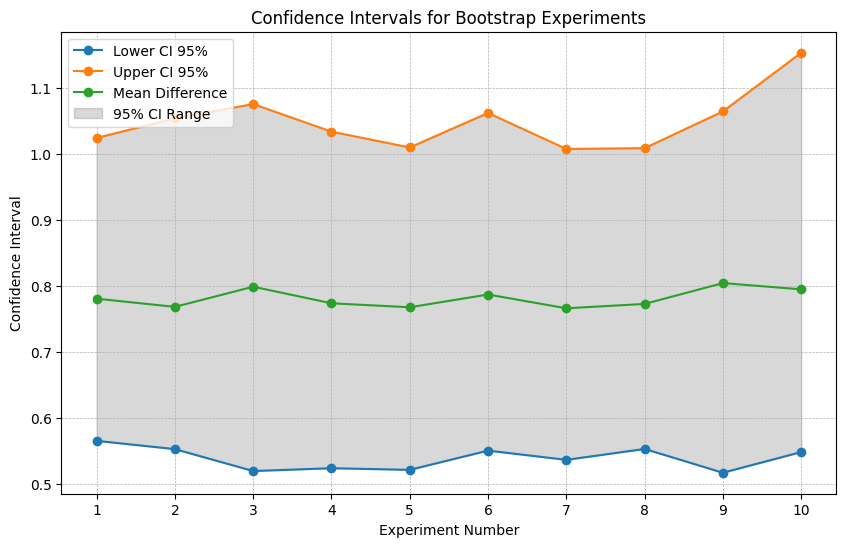

In [11]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [12]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,0.780524,0.564802,1.024483,1
1,0.768101,0.552250,1.054009,2
2,0.798666,0.519004,1.075858,3
3,0.773540,0.523283,1.033957,4
4,0.767476,0.520805,1.009979,5
5,0.786849,0.549999,1.062330,6
6,0.765940,0.535988,1.007684,7
7,0.772542,0.552515,1.008944,8
8,0.804179,0.516445,1.064615,9
9,0.794699,0.547781,1.153714,10


### Observational data

In [13]:
lalonde_obs.loc[lalonde_obs["treat"] == 1, "u78"].mean() / lalonde_obs.loc[
    lalonde_obs["treat"] == 0, "u78"
].mean()

2.117747117747118

In [14]:
backdoor_result = backdoor_classifier(
    lalonde_obs,
    "treat",
    "u78",
    ["age", "education", "black", "hispanic", "married", "u74", "u75"],
    "DecisionTree",
)
print(f"The risk ratio is {backdoor_result:.2f}")

The risk ratio is 2.73


In [15]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_classifier,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="u78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "u74",
        "u75",
    ],
    classifier_name="DecisionTree",
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


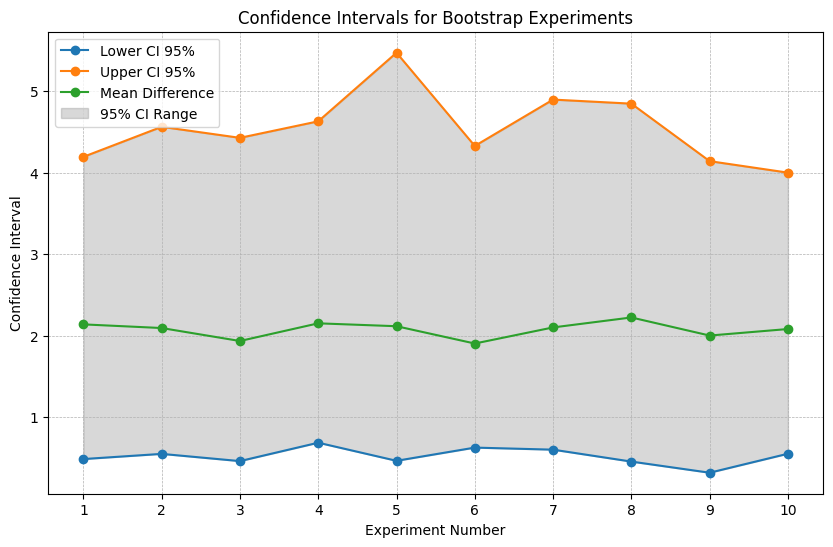

In [16]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [17]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,2.137775,0.483292,4.195738,1
1,2.092892,0.546878,4.564776,2
2,1.933561,0.458157,4.429296,3
3,2.150691,0.684154,4.632264,4
4,2.115175,0.461828,5.474965,5
5,1.902577,0.624074,4.329685,6
6,2.100326,0.598662,4.899272,7
7,2.222692,0.452248,4.849233,8
8,2.000551,0.315452,4.142932,9
9,2.080694,0.548743,4.001745,10
